# Super-Resolution GAN

This project implements a generative adversarial network for the single-image super-resolution task. The implementation is based on the Super-Resolution GAN (SR-GAN) [1] and Enhanced Super-Resolution GAN (ESR-GAN) [2] papers. 

### Importing libraries, downloading dataset, and preparing dataset directory structure

In [ ]:
import torch
from torch.utils.data import DataLoader
from torch.nn.functional import interpolate

from torchvision.datasets import ImageFolder
from torchvision import transforms

import cv2

import matplotlib.pyplot as plt

For this project, we train and test our model on the BSDS5300 dataset[3], a high-resolution segmentation dataset with a variety of subjects and scenes. The dataset contains 200 training images and 100 test images.

Note: Downloading the dataset is only required to run the training and quantitative results sections of this notebook. The qualitative results can be run with the incldued weights and image files in this repo.

In [ ]:
!wget https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300-images.tgz
!mkdir -p data
!tar -xzf BSDS300-images.tgz -C data
!mkdir -p data/BSDS300/images/test/cls
!mkdir -p data/BSDS300/images/train/cls
!mv data/BSDS300/images/train/*.jpg data/BSDS300/images/train/cls
!mv data/BSDS300/images/test/*.jpg data/BSDS300/images/test/cls

### Model Training

Running this section is computationally demanding and optional. You can instead opt to use the provided pre-trained weights.

In [ ]:
!python3 src/train.py

### Model Evaluation

To evaluate the model, we apply a downscaling operation to the BSDS300 test dataset and test the model's ability to restore the images to their original resolution. We utilize bicubic interpolation upscaling as a baseline for comparison.

Note: The quantitative results require downloading the dataset but the qualitative results can be run with the image files provided in this repo.

#### Quantitative Results

The first experiment quantatively compares the outputs of our method and the baseline on the peak signal-to-noise (PSNR) metric. As noted in the SR-GAN paper, this metric is somewhat flawed because it rewards heavily-smoothing outputs, which can destroy fine-grained textures.

In [ ]:
#Loading in trained generator
gan_model = torch.load('weights/generator_final.torch')

In [13]:
#Loading in BSDS300 test set
#Images are cropped to 300x300 to deal with differences in orientation
test_ds = ImageFolder('data/BSDS300/images/test', transform=transforms.Compose([transforms.RandomCrop(300), transforms.ToTensor()]))
test_dl = DataLoader(test_ds, batch_size=2)

#Main quantitative evaluation loop
psnr_gan = 0
psnr_bc = 0
for i, batch in enumerate(test_dl):
    with torch.no_grad():
        high_imgs = batch[0]
        #Downsampling reference images
        low_imgs = interpolate(high_imgs, scale_factor=1/4, mode='bicubic')

        #Generating super-resolution images with bicubic and GAN model
        bc_imgs = interpolate(low_imgs, scale_factor=4, mode='nearest')
        gan_imgs = gan_model(low_imgs)
    
        #Computing MSE for GAN and bicubic
        bc_mse = torch.mean((bc_imgs-high_imgs)**2, dim=(1,2,3))
        gan_mse = torch.mean((gan_imgs-high_imgs)**2, dim=(1,2,3))
    
        #Computing GAN and bicubic PSNR for this batch and adding to running total
        psnr_gan += torch.sum(20*torch.log10(1/torch.sqrt(gan_mse)))
        psnr_bc += torch.sum(20*torch.log10(1/torch.sqrt(bc_mse)))
#Taking average PSNR over dataset
psnr_gan /= len(test_ds)
psnr_bc /= len(test_ds)

print(f'PSNR GAN: {psnr_gan}')
print(f'PSNR Bicubic: {psnr_bc}')

PSNR GAN: 21.566415786743164
PSNR Bicubic: 21.683351516723633


Similar to SR-GAN, our model is slightly outperformed by bicubic interpolation on the PSNR metric. This is expected since the model is trained to prioritize texture/feature sharpness.

#### Qualitative Results

In the next experiment, we demonstrate the superior visual quality of our model's outputs by qualitative assesment. To do this, we visually inspect the outputs of our model and the baseline on a few select test images. 

In [ ]:
'''
Visualizes the bicubic interpolation and GAN outputs of a single test image
Plot shows the full image outputs of both methods, as well as a selected zoom region to inspect finer textures/details
Original image is also visualzied for comparison
Zoom region given as [min_y, max_y, min_x, max_x]
'''
def visualize_outputs(img_file, zoom_range):
    img = cv2.cvtColor(cv2.imread(img_file), cv2.COLOR_BGR2RGB)
    img = transforms.ToTensor()(img)

    #Downscaling img
    img = img.unsqueeze(dim=0)
    low_img = interpolate(img, scale_factor=1/4, mode='bicubic')

    #Upscaling with Bicubic and GAN
    bc_img = interpolate(low_img, scale_factor=4, mode='nearest')
    gan_img = gan_model(low_img).detach()
    

    _f, axs = plt.subplots(2, 3, figsize=(24, 12))

    imgs_to_plot = [img, bc_img, gan_img]
    for idx, pimg in enumerate(imgs_to_plot):
        #prepping image for matplotlib
        pimg = pimg.squeeze().permute(1,2,0)
        #Display full image
        axs[0, idx].imshow(pimg)
        #Display
        axs[1, idx].imshow(pimg[zoom_range[0]:zoom_range[1], zoom_range[2]:zoom_range[3], :])
    
    names = ['Original', 'Bicubic', 'GAN']
    for idx, name in enumerate(names):
        axs[0, idx].set_title(name, size=24)
    
    plt.show()
    




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.041134346..1.0872817].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.041134346..1.0609604].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.03987931..1.1485418].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.003225224..1.1485418].


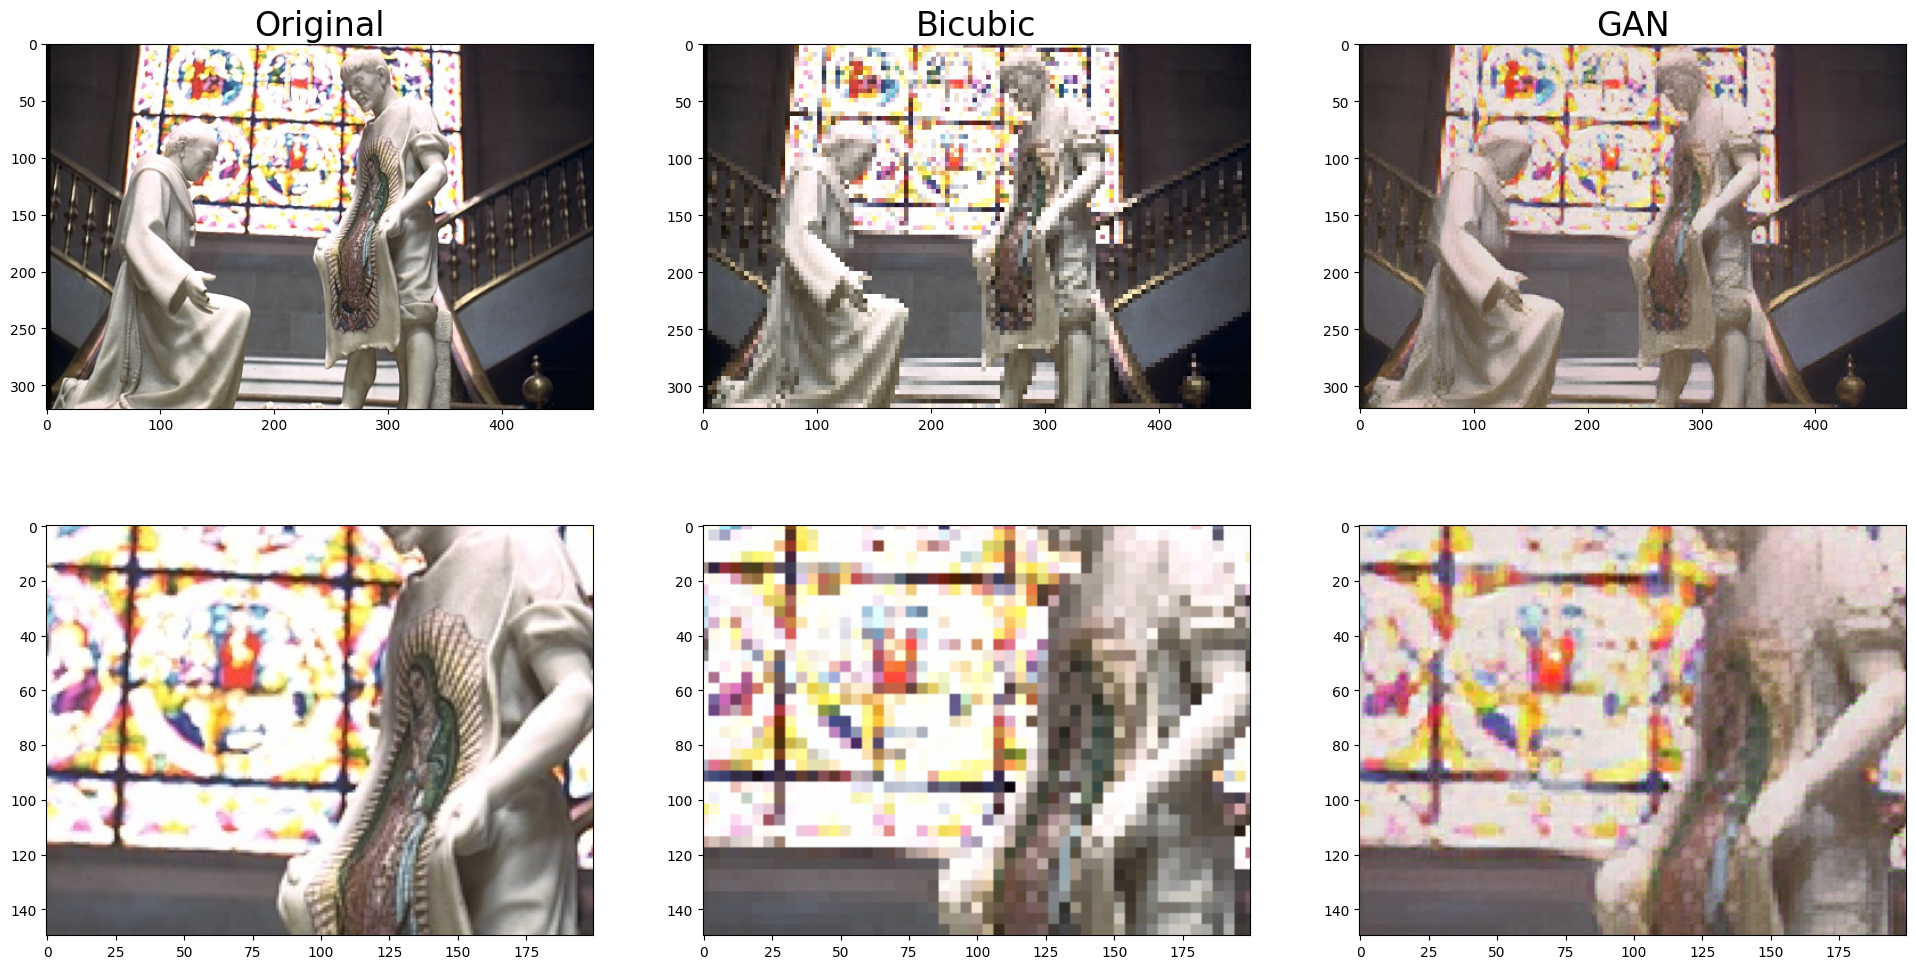

In [22]:
visualize_outputs('qual_imgs/statue.jpg', [50, 200, 150, 350])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04008502..1.0647326].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.026344208..1.0426242].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0721534..0.8925651].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.023955867..0.88151366].


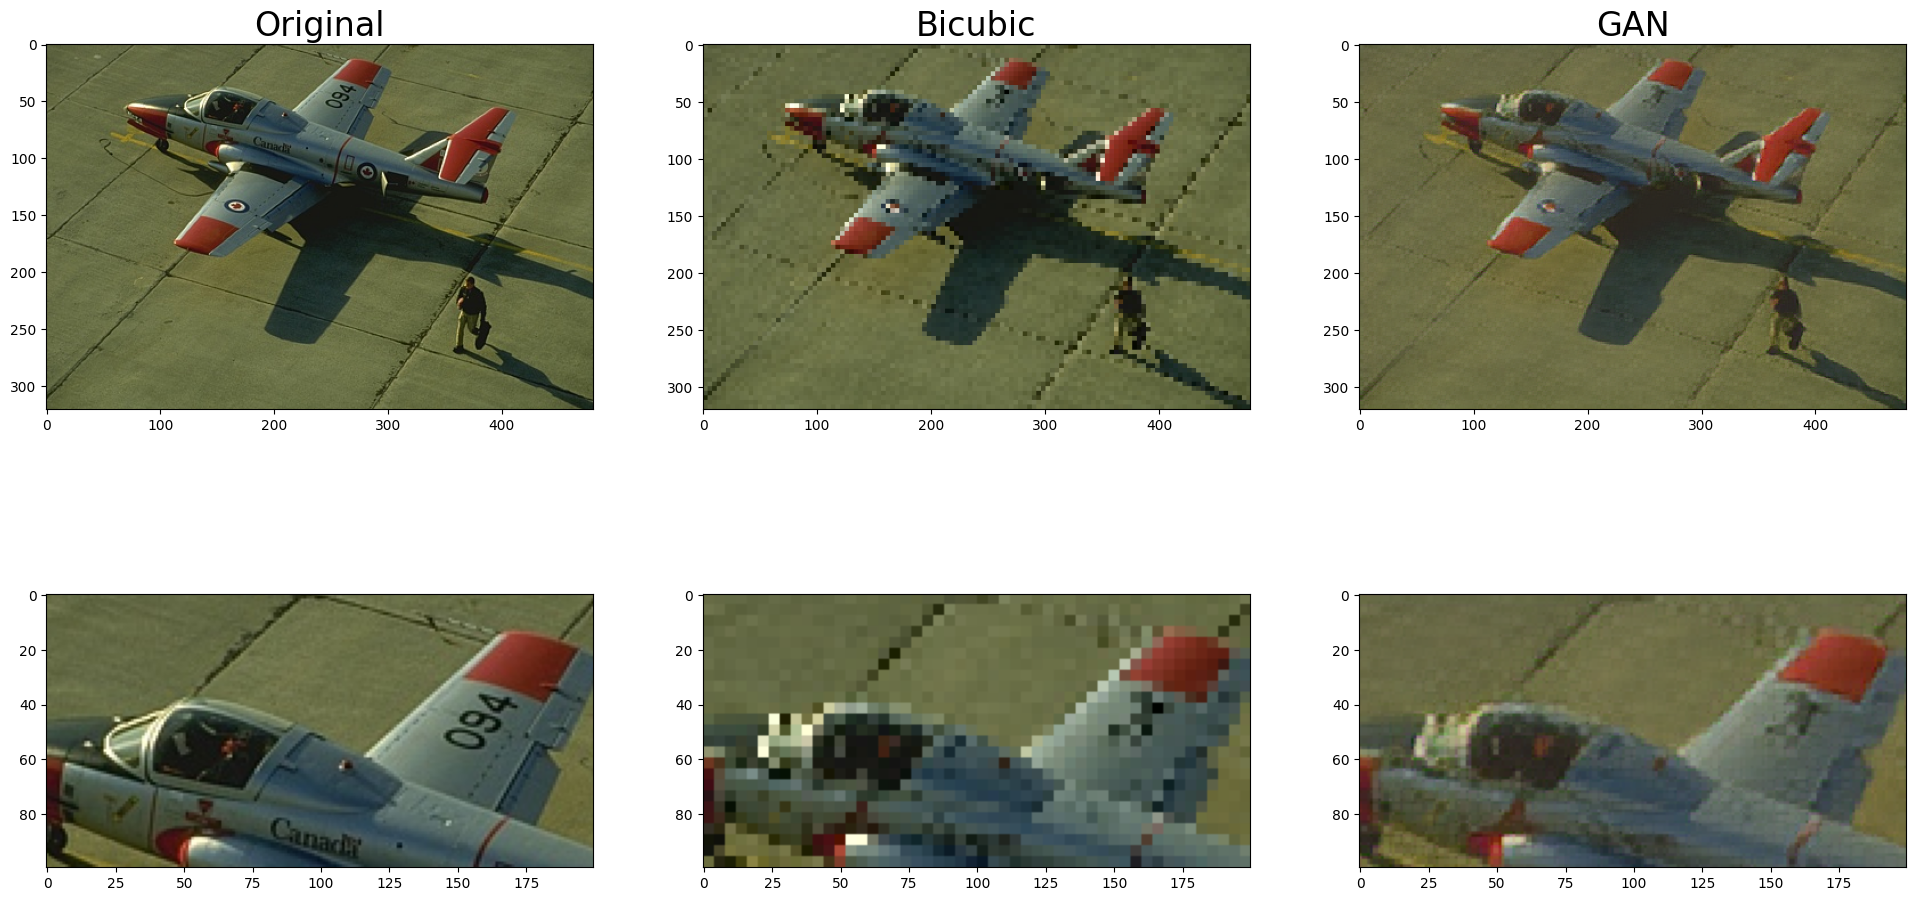

In [16]:
visualize_outputs('qual_imgs/plane.jpg', [0, 100, 100, 300])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.067455575..1.1089307].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.17072304..1.185035].


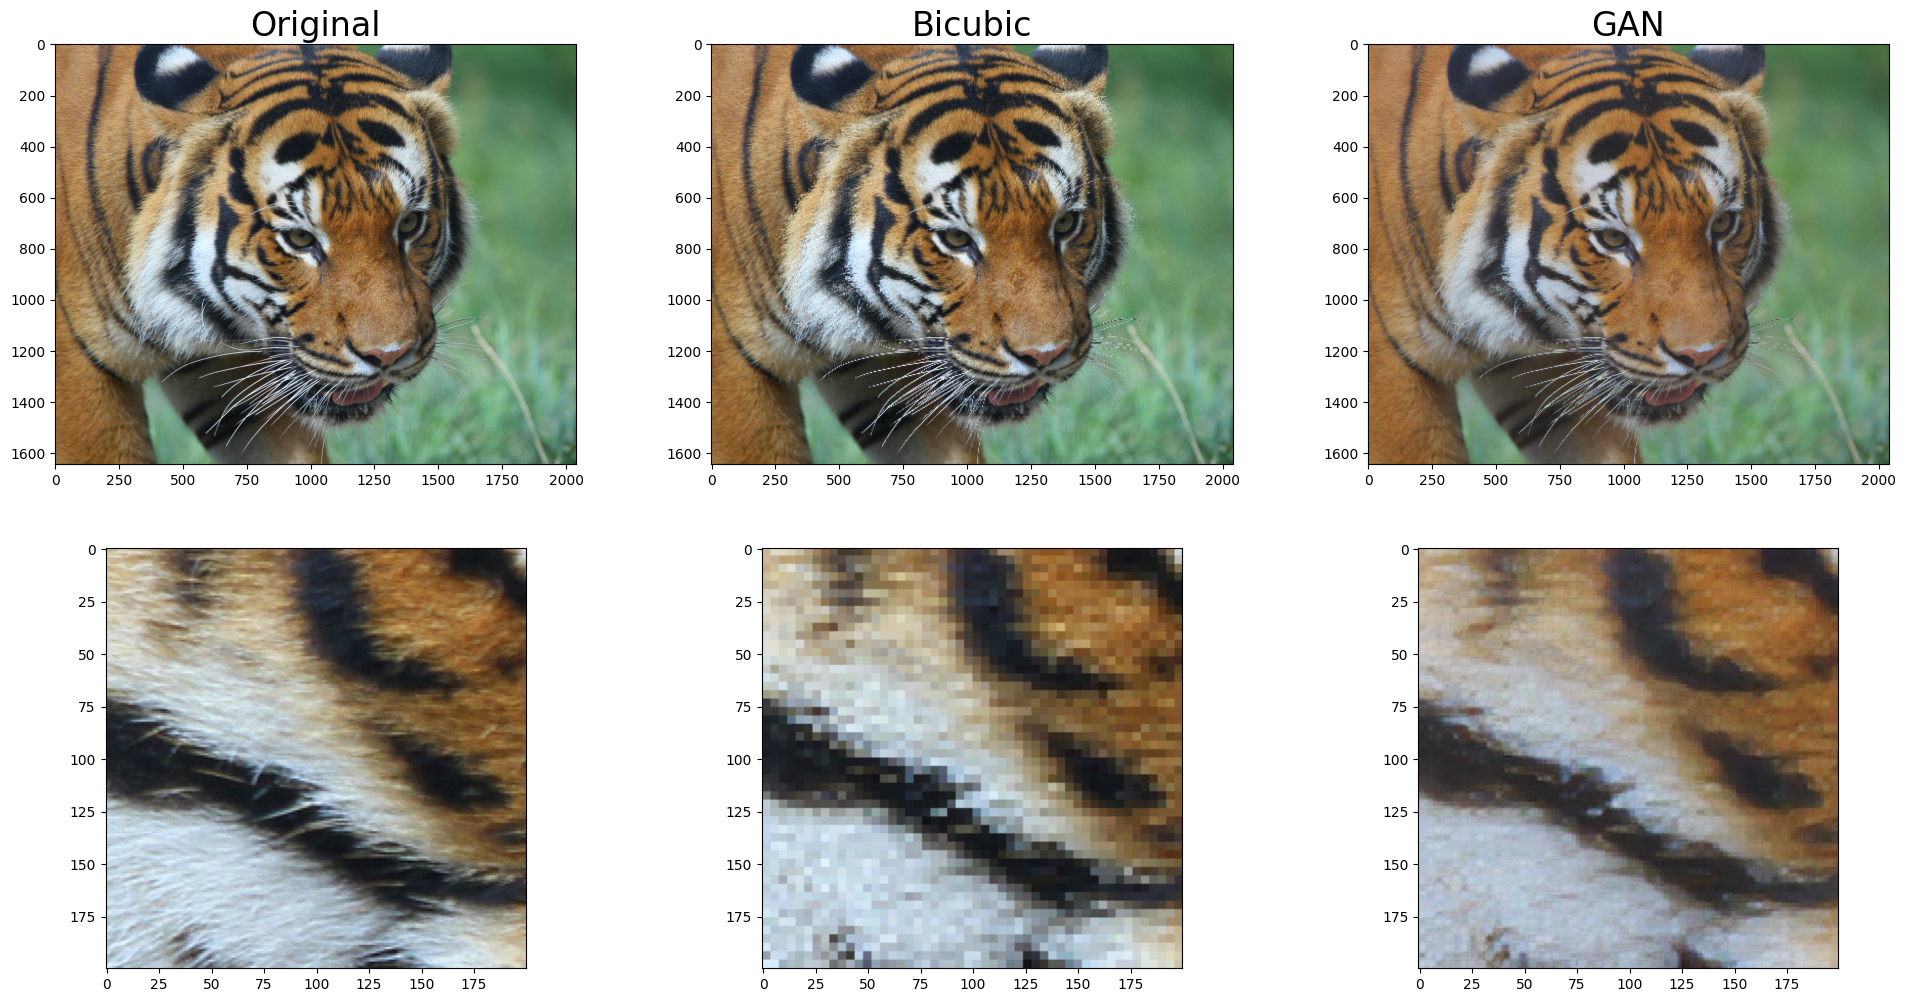

In [14]:
#Testing very high resolution image not from BSD300
#Photo sourced from wikipedia. Photo by Greg Hume.
visualize_outputs('qual_imgs/tiger.png', [800, 1000, 700, 900])

### Sources

[1] Ledig, Christian, et al. "Photo-realistic single image super-resolution using a generative adversarial network." Proceedings of the IEEE conference on computer vision and pattern recognition. 2017.

[2] Wang, Xintao, et al. "Esrgan: Enhanced super-resolution generative adversarial networks." Proceedings of the European conference on computer vision (ECCV) workshops. 2018. 

[3] Martin, David, et al. "A database of human segmented natural images and its application to evaluating segmentation algorithms and measuring ecological statistics." Proceedings eighth IEEE international conference on computer vision. ICCV 2001. Vol. 2. IEEE, 2001.